# Exploratory Data Analysis
This notebook explores the output of the TML analysis pipeline performed on a variety of countries in our processing extent. The visualizations are intended to explore statistics across different ESA and IPCCC land cover categories and compare tree cover estimates between TML and Hansen et al (2013).

**Check Statistics**  

**Tree Cover per Land Cover Class**  
TML tree cover assessments per ESA land cover classifications
* Sampled Area: Country
* Sampled Area: Admin and lcc
* Urban Areas in El Salvador
* Tree Cover (ha) per lcc

TML tree cover assessments per IPCC land cover classifications
* TML above thresholds
* Urban Areas in El Salvador and Guatemala
 
**Old Visualizations**  


In [ ]:
import os
import rasterio as rs
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd 
import pandas as pd

from rasterio.plot import show
from numpy.ma import masked_array
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
from matplotlib.patches import Patch

## Check Statistics Spreadsheets

In [ ]:
def check_stats(country):
    '''
    Checks a country's statistics spreadsheet for erroneous values
    '''
    
    df = pd.read_csv(f'/Volumes/Jessicas_Life/_Processed_countries/{country}/stats/{country}_statistics.csv')
    print(f'SUMMARY FOR {country}:')
    print(df.info())
    print(' ')
    print(f'ESA LAND COVER CLASSES: {df.esa_class.nunique()}')
    print(df.esa_class.value_counts())
    print(' ')
    print(f'TOF means >100%: {len(df[df.tof_mean >= 100])}')
    print(f'Hans means >100%: {len(df[df.hans_mean >= 100])}')
    print(f'TOF NaN means: {len(df[df.tof_mean.isnull()])}')
    print(f'Hans NaN means: {len(df[df.hans_mean.isnull()])}')
    print(f'Confirm no ha if no mean: {len(df[(df.tof_mean == 0) & (df.tof_ha > 0)])}')
    print(' ')
    print('% LAND COVER THAT IS NaN')
    print(df[df.tof_mean.isnull()].esa_class.value_counts(normalize=True)*100)
    return df[:40]

In [ ]:
check_stats('Guinea Bissau')

In [ ]:
ipcc_colors = {'Other':'royalblue',
               'Agriculture':'sandybrown',
               'Forest':'green',
               'Grassland':'limegreen',
               'Wetland':'mediumturquoise',
               'Settlement':'palevioletred'}

In [ ]:
colors = ['royalblue','maroon', 'gray', 'sandybrown', 
          'gold', 'limegreen', 'green', 'palevioletred',
          'mediumturquoise', 'red', 'cyan', 'sienna', 'navy', 
          'mediumpurple', 'darkkhaki', 'magenta']

In [ ]:
# create dataframes for each category of lc class

tree_cover_class = landcover[landcover.esa_id.isin([50, 60, 70, 80, 90, 160, 170])]
mosaic_class = landcover[landcover.esa_id.isin([30, 40, 100, 110])]
crop_urban_class = landcover[landcover.esa_id.isin([10, 11, 20, 190])]
herb_shrub_class = landcover[landcover.esa_id.isin([120, 130, 140, 150, 180, 200])]
other_class = landcover[landcover.esa_id.isin([0, 210, 220])]

## ESA and TML
TML tree cover assessments per ESA land cover classifications. Some sections compare TML estimates to Hansen et al per land cover class.

### Sampling Area: Country
This barchart illustrates the sampling coverage for each land cover class in a country. Each bar shows the sampled and total hectares of each land cover class in hectares (any hectare containing >0% tree cover is included). The results are sorted by hectares of land cover sampled in ascending order.

In [ ]:
def lc_sampled(country):
    
    df = pd.read_csv(f'/Volumes/Jessicas_Life/_Processed_countries/{country}/stats/{country}_statistics.csv')
    df = df[['country', 'admin', 'esa_class', 'esa_sampled_ha', 'esa_total_ha']]

    df = df.drop_duplicates(keep='first', ignore_index=True)
    df.drop(df[df.esa_class == 'No Data (flag)'].index, inplace = True)
    df['esa_not_sampled'] = df['esa_total_ha'] - df['esa_sampled_ha']
    df = df.groupby(by='esa_class').sum().reset_index()
    df = df.sort_values(by='esa_sampled_ha')
    df['esa_perc_sampled'] = round((df['esa_sampled_ha'] / df['esa_total_ha']) * 100)
    
    # create the visualization
    plt.figure(figsize=(10,5))
    classes = list(df.esa_class.values)
    bars1 = df.esa_sampled_ha
    bars2 = df.esa_not_sampled

    plt.barh(classes, bars1, color="#f3e151", label='sampled')  
    plt.barh(classes, bars2, left=bars1, color="#6c3376", label='not sampled')

    plt.title(f'Land Cover Sampled in {country}')
    plt.xlabel('Tree Cover (ha)')
    plt.ticklabel_format(useOffset=False, style='plain', axis='x')
    plt.grid(axis='x', linestyle='-', linewidth=.2)
    plt.legend();
    
    return

In [ ]:
lc_sampled('Belize')

In [ ]:
lc_sampled('El Salvador')

In [ ]:
lc_sampled('Nicaragua')

In [ ]:
lc_sampled('Honduras')

In [ ]:
lc_sampled('Panama')

In [ ]:
lc_sampled('Guatemala')

In [ ]:
lc_sampled('Costa Rica')

### Sampling Area: Admin and Land Cover Class
The following functions are intended to return the total area sampled at various scales (at a land cover class and administrative district scale).

In [ ]:
# get the total area sampled in Cayo, Belize for land cover class 11
df = pd.read_csv(f'/Volumes/Jessicas_Life/regional_stats/central_am.csv')
cayo11 = df[(df.admin == 'Cayo') & (df.esa_id == 11)]
cayo11_sampled = round((cayo11.esa_sampled_ha.iloc[0] / cayo11.esa_total_ha.iloc[0]) * 100, 2)
print(f'The total area sampled in Cayo, Belize for ESA land cover #11 is: {cayo11_sampled}%')

In [ ]:
## Admins with most area sampled
df_samp = df[['country', 'admin', 'esa_id', 'esa_sampled_ha', 'esa_total_ha']] 
df_samp = df_samp.drop_duplicates(keep='first', ignore_index=True)

# group by country and admin, sum sampled ha and total ha
df_admin_samp = df_samp.groupby(by=['country', 'admin']).sum().reset_index()
df_admin_samp = df_admin_samp[['country', 'admin', 'esa_sampled_ha', 'esa_total_ha']] 
df_admin_samp['perc_sampled'] = round((df_admin_samp.esa_sampled_ha / df_admin_samp.esa_total_ha * 100), 2)

df_admin_samp

most_sampled = df_admin_samp.sort_values('perc_sampled', ascending=(False))
most_sampled[:10]cayo = df[df.admin == 'Cayo']
cayo_samp = cayo[['country', 'admin', 'esa_id', 'esa_sampled_ha', 'esa_total_ha']] 
cayo_samp = cayo_samp.drop_duplicates(keep='first', ignore_index=True)
cayo_sampled = round((cayo_samp.esa_sampled_ha.sum() / cayo_samp.esa_total_ha.sum()) * 100, 2)
print(f'The total area sampled in Cayo, Belize is: {cayo_sampled}%')

In [ ]:
## Admins with most area sampled
df_samp = df[['country', 'admin', 'esa_id', 'esa_sampled_ha', 'esa_total_ha']] 
df_samp = df_samp.drop_duplicates(keep='first', ignore_index=True)

# group by country and admin, sum sampled ha and total ha
df_admin_samp = df_samp.groupby(by=['country', 'admin']).sum().reset_index()
df_admin_samp = df_admin_samp[['country', 'admin', 'esa_sampled_ha', 'esa_total_ha']] 
df_admin_samp['perc_sampled'] = round((df_admin_samp.esa_sampled_ha / df_admin_samp.esa_total_ha * 100), 2)

In [ ]:
df_admin_samp

In [ ]:
most_sampled = df_admin_samp.sort_values('perc_sampled', ascending=(False))
most_sampled[:10]

### Common Land Covers (per country)
The following horizontal barcharts visualize the most common IPCC and ESA land cover classes for a specific country, in descending order.

In [ ]:
def lcc_country_countplot(country, data, figsize):
    
    '''
    Plots a seaborn countplot of the number of pixels that fall into each land cover class. 
    First plot is for ESA, second is for IPCC. 
    '''
    
    plt.figure(figsize=figsize)

    # plot ESA class counta
    ax1 = plt.subplot(2,1,1)
    sns.countplot(y='esa_class',
              data=data,
              palette='Greens_r',
              order=data.esa_class.value_counts().index,
              ax=ax1)
    ax1.set_title(f'ESA Land Cover Classes in {country}')
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel(' ');
    
    
    # plot IPCC class count
    ax2 = plt.subplot(2,1,2)
    sns.countplot(y='ipcc_class',
                  data=data,
                  palette='Greens_r',
                  order=data.ipcc_class.value_counts().index,
                  ax=ax2)
    ax2.set_title(f'IPCC Land Cover Classes in {country}')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel(' ')
    
    plt.tight_layout;
    
    return None

In [ ]:
lcc_country_countplot('El Salvador', es_above, (10,10))

In [ ]:
lcc_country_countplot('San Miguel', san_mig, (10,10))

### Urban Areas: El Salvador
What does tree cover look like in the urban land cover class?  
How can we visualize the portion of urban tree cover that meets the FAO forest cover criterion of >10% tree cover?

In [ ]:
# get the sum of ha of tree cover for each 10% threshold
es = pd.read_csv('El Salvador/El Salvador_statistics.csv')
urban = es[es.esa_id == 190]
urban = urban.groupby(by=['admin', 'tree_cover_class']).sum().reset_index()
urban = urban[['admin', 'tree_cover_class', 'esa_sampled_ha', 'esa_total_ha', 'tof_ha']]
urban_usulutan = urban[urban.admin == 'Usulután']

plt.figure(figsize = (8,6))
x = ['0-9%','10-19%','20-29%','30-39%','40-49%','50-59%','60-69%','70-79%','80-89%','90-99%']
#x = list(sorted(set(urban_usulutan.tree_cover_class)))

variance = [15, 20, 4, 12, 4, 5, 10, 6, 8, 10]

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, list(urban_usulutan.tof_ha), color='green', xerr=variance)
plt.ylabel(" ")
plt.xlabel("Total ha")
plt.title("Urban Tree Cover by Threshold: Usulután, El Salvador")

plt.yticks(x_pos, x);

In [ ]:
def urban_triptych(tml_filepath, esa_filepath, admin):
    
    tml = rs.open(tml_filepath).read(1)
    esa = rs.open(esa_filepath).read(1)

    # mask out no data values for plotting
    tml_ma = np.ma.masked_where(tml == 255, tml, copy=True)
    esa_ma = np.ma.masked_where(esa == 255, esa, copy=True)

    # mask out non-urban land covers
    esa_ma_urban = masked_array(esa_ma, esa_ma != 190.) 
    tml_urban = masked_array(tml_ma, esa_ma != 190.)


    plt.figure(figsize=(20,20))
    fontsize = 18

    # plot admin with urban land cover overlay
    plt.subplot(1,3,1)
    plt.imshow(tml_ma, cmap='Greens', vmin=0, vmax=100)
    plt.imshow(esa_ma_urban, cmap='Reds_r')
    plt.title(f'Urban Land Cover in {admin}', fontsize=fontsize)
    plt.axis('off')

    # plot tree cover in urban land cover class only
    plt.subplot(1,3,2)
    plt.imshow(tml_urban, cmap='Greens')
    plt.title(f'Tree Cover in Urban Areas in {admin}', fontsize=fontsize)
    plt.axis('off')

    # plot tree cover across admin and binary map for 10% threshold
    plt.subplot(1,3,3)
    cmap = ListedColormap(['mediumpurple', 'navy'])
    norm = colors.BoundaryNorm([0, 10, 50], cmap.N) # .N is count
    plt.imshow(tml_ma, cmap='Greens', vmin=0, vmax=100)
    binary_map = plt.imshow(tml_urban, cmap=cmap, norm=norm)
    plt.title(f"Tree Cover Above and Below \n 10% Threshold in {admin}", fontsize=fontsize)
    #plt.colorbar(binary_map, boundaries=bounds, ticks=[0, 10, 100], shrink=0.25)
    plt.axis('off')

    # add legend
    legend_labels = {'navy':'>10% tree cover','mediumpurple':'<10% tree cover'}
    patches = [Patch(color=color, label=label)
               for color, label in legend_labels.items()]
    plt.legend(handles=patches,
              bbox_to_anchor=(1.35, 1),
              facecolor="white",
              fontsize=14)
    
    plt.tight_layout();
    return None

In [ ]:
urban_triptych('El Salvador/San Salvador.tif', 
                  'El Salvador/San Salvador_esa.tif', 
                  'San Salvador')

In [ ]:
urban_triptych('El Salvador/Usulután.tif', 
                  'El Salvador/Usulután_esa.tif', 
                  'Usulután')

In [ ]:
urban_triptych('El Salvador/La Libertad.tif', 
                  'El Salvador/La Libertad_esa.tif', 
                  'La Libertad')

In [ ]:
urban_triptych('El Salvador/Morazán.tif', 
                  'El Salvador/Morazán_esa.tif', 
                  'Morazán')

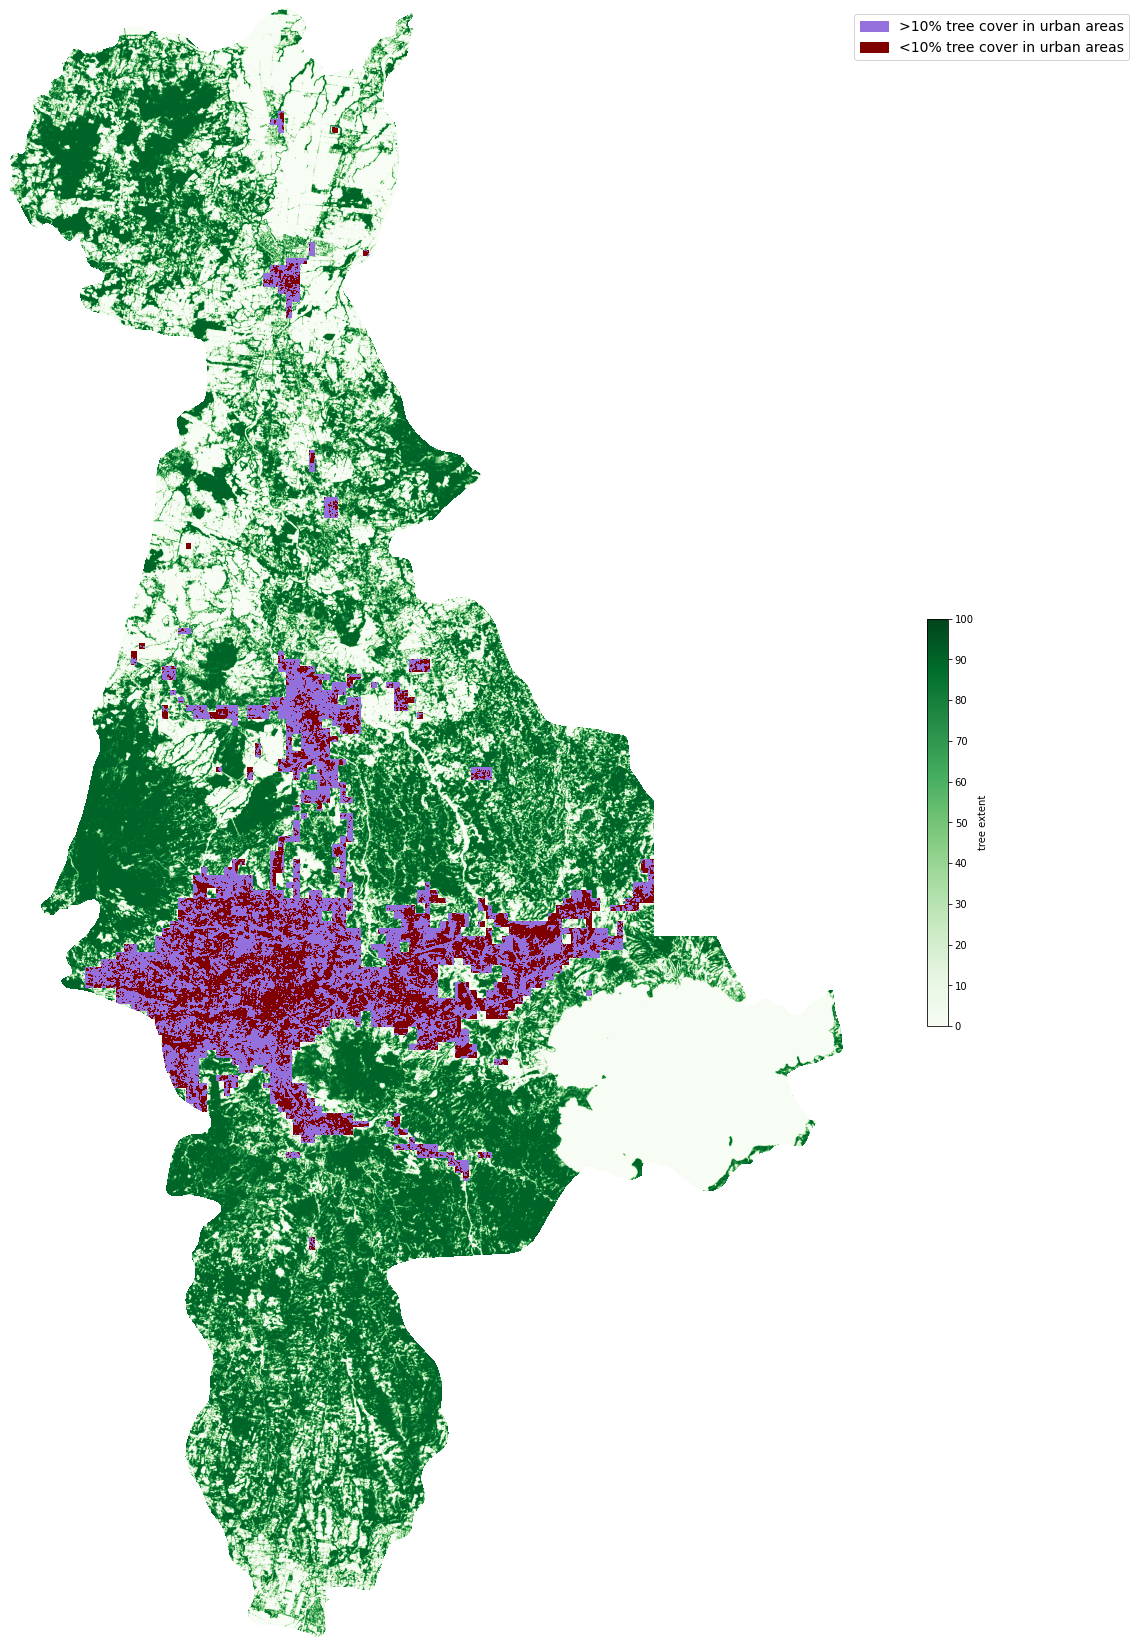

In [8]:
plt.figure(figsize=(30,30))
fontsize = 16
cmap = ListedColormap(['maroon', 'mediumpurple'])
norm = colors.BoundaryNorm([0, 10, 50], cmap.N) # .N is count
tree_cover = plt.imshow(tml_ma, cmap='Greens', vmin=0, vmax=100)
binary_map = plt.imshow(tml_urban, cmap=cmap, norm=norm)
#plt.title(f"Tree Cover Above and Below \n 10% Threshold in San Salvador, El Salvador", fontsize=fontsize)
plt.axis('off')
plt.colorbar(tree_cover, ticks=np.arange(0,110,10), shrink=0.25, label='tree extent')

#add legend
legend_labels = {'mediumpurple':'>10% tree cover in urban areas','maroon':'<10% tree cover in urban areas'}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
plt.legend(handles=patches,
          bbox_to_anchor=(1.35, 1),
          facecolor="white",
          fontsize=14);
    

### Total Hectares per Class: Hansen v TOF
What does the distribution look like across all land cover classes?

In [ ]:
# All land cover classes 
fig, ax = plt.subplots(figsize=(12,10))

sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=landcover, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors,
               ax=ax)
ax.set(xlim=(0, 8000), ylim=(0, 8000))
ax.plot(np.arange(0.001, 8000, 1), color='grey', linewidth=.2)
ax.set_title('Hectares of Tree Cover per Land Cover Class')
ax.set_xlabel('TOF total hectares')
ax.set_ylabel('Hansen total hectares')


plt.legend(bbox_to_anchor=(1.0, 1), title='ESA Land Cover Class');

In [ ]:
# All land cover classes for obs <2000ha
fig, ax = plt.subplots(figsize=(12,10))

sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=under2k, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors,
               ax=ax)
ax.set(xlim=(0, 2000), ylim=(0, 2000))
ax.plot(np.arange(0.001, 3000, 1), color='grey', linewidth=.2)
ax.set_title('Hectares of Tree Cover per Land Cover Class (obs <2000ha)')
ax.set_xlabel('TOF total hectares')
ax.set_ylabel('Hansen total hectares')


plt.legend(bbox_to_anchor=(1.0, 1), title='ESA Land Cover Class');

In [ ]:
ipcc_means(es_above_new, (13,7), 'El Salvador (median bins)')

In [ ]:
plt.figure(figsize=(13,7))

width = 0.4
pos1 = np.arange(len(nic_ipcc_means))
pos2 = pos1 + width

sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=under500, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors,
               ax=ax)
ax.set(xlim=(0, 500), ylim=(0, 500))
ax.plot(np.arange(0.001, 500, 1), color='grey', linewidth=.2)
ax.set_title('Hectares of Tree Cover per Land Cover Class (obs <500ha)')
ax.set_xlabel('TOF total hectares')
ax.set_ylabel('Hansen total hectares')

plt.legend(bbox_to_anchor=(1.0, 1), title='ESA Land Cover Class');

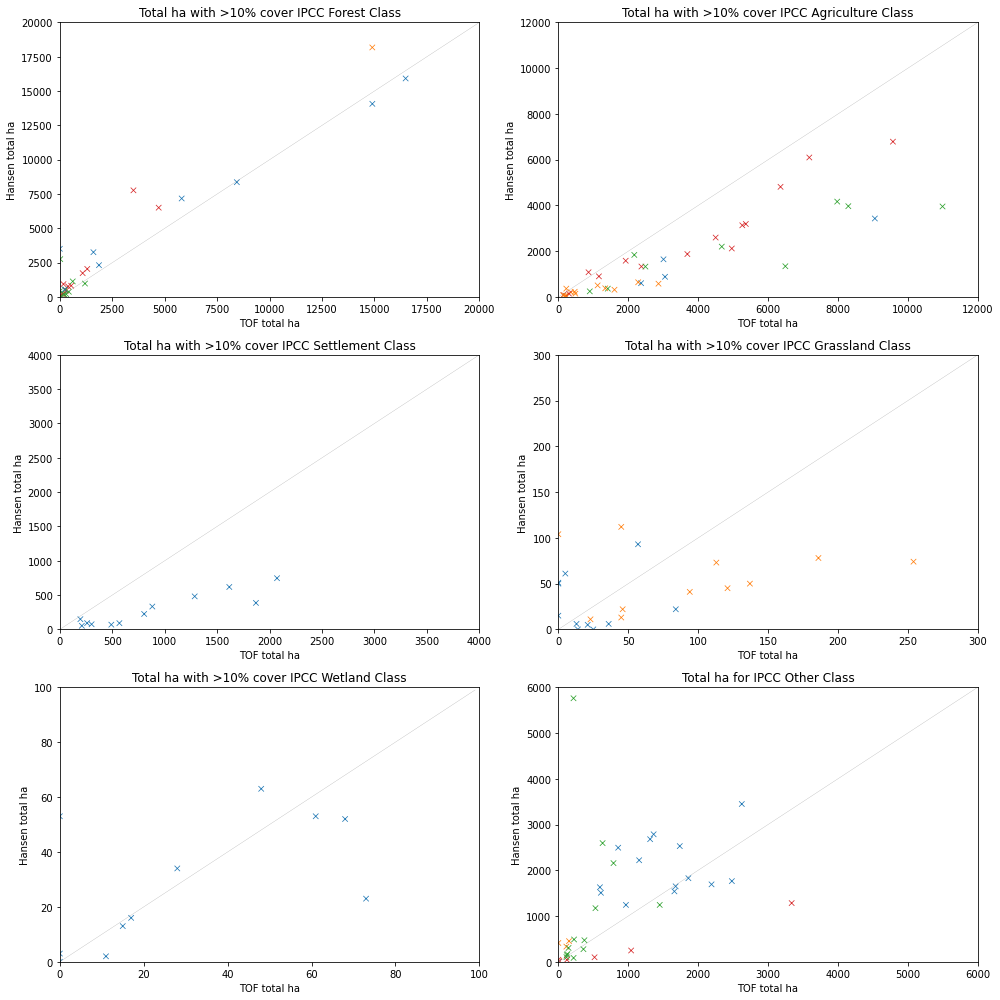

In [96]:
# El Salvador: total ha >10% cover per IPCC class

forest = es_above[es_above.ipcc_class == 'Forest']
agriculture = es_above[es_above.ipcc_class == 'Agriculture']
settlement = es_above[es_above.ipcc_class == 'Settlement']
grassland = es_above[es_above.ipcc_class == 'Grassland']
wetland = es_above[es_above.ipcc_class == 'Wetland']
other = es_above[es_above.ipcc_class == 'Other']

plt.figure(figsize=(14,14))

ax1 = plt.subplot(3,2,1)
sns.scatterplot(x='tof_10+', 
               y='hans_10+', 
               data=forest, 
               hue='esa_class',
               marker='x',
               s=30,
               #palette=colors[:5],
               ax=ax1,
               legend=False)
ax1.set(xlim=(0, 20000), ylim=(0, 20000))
ax1.plot(np.arange(0.001, 20000, 1), color='grey', linewidth=.2)
ax1.set_title('Total ha with >10% cover IPCC Forest Class')
ax1.set_xlabel('TOF total ha')
ax1.set_ylabel('Hansen total ha')

ax2 = plt.subplot(3,2,2)
sns.scatterplot(x='tof_10+', 
               y='hans_10+', 
               data=agriculture, 
               hue='esa_class',
               marker='x',
               s=30,
               #palette=colors[4:8],
               ax=ax2,
               legend=False)
ax2.set(xlim=(0, 12000), ylim=(0, 12000))
ax2.plot(np.arange(0.001, 12000, 1), color='grey', linewidth=.2)
ax2.set_title('Total ha with >10% cover IPCC Agriculture Class')
ax2.set_xlabel('TOF total ha')
ax2.set_ylabel('Hansen total ha')


ax3 = plt.subplot(3,2,3)
sns.scatterplot(x='tof_10+', 
               y='hans_10+', 
               data=settlement, 
               hue='esa_class',
               marker='x',
               s=30,
               #palette=colors[8:9],
               ax=ax3,
               legend=False)
ax3.set(xlim=(0, 4000), ylim=(0, 4000))
ax3.plot(np.arange(0.001, 4000, 1), color='grey', linewidth=.2)
ax3.set_title('Total ha with >10% cover IPCC Settlement Class')
ax3.set_xlabel('TOF total ha')
ax3.set_ylabel('Hansen total ha')

ax4 = plt.subplot(3,2,4)
sns.scatterplot(x='tof_10+', 
               y='hans_10+', 
               data=grassland, 
               hue='esa_class',
               marker='x',
               s=30,
               #palette=colors[9:11],
               ax=ax4,
               legend=False)
ax4.set(xlim=(0, 300), ylim=(0, 300))
ax4.plot(np.arange(0.001, 1000, 1), color='grey', linewidth=.2)
ax4.set_title('Total ha with >10% cover IPCC Grassland Class')
ax4.set_xlabel('TOF total ha')
ax4.set_ylabel('Hansen total ha')

ax5 = plt.subplot(3,2,5)
sns.scatterplot(x='tof_10+', 
               y='hans_10+', 
               data=wetland, 
               hue='esa_class',
               marker='x',
               s=30,
               #palette=colors[11:12],
               ax=ax5,
               legend=False)
ax5.set(xlim=(0, 100), ylim=(0, 100))
ax5.plot(np.arange(0.001, 100, 1), color='grey', linewidth=.2)
ax5.set_title('Total ha with >10% cover IPCC Wetland Class')
ax5.set_xlabel('TOF total ha')
ax5.set_ylabel('Hansen total ha')

ax6 = plt.subplot(3,2,6)
sns.scatterplot(x='tof_10+', 
               y='hans_10+', 
               data=other, 
               hue='esa_class',
               marker='x',
               s=30,
               #palette=colors[12:],
               ax=ax6,
               legend=False)
ax6.set(xlim=(0, 6000), ylim=(0, 6000))
ax6.plot(np.arange(0.001, 6000, 1), color='grey', linewidth=.2)
ax6.set_title('Total ha for IPCC Other Class')
ax6.set_xlabel('TOF total ha')
ax6.set_ylabel('Hansen total ha')

# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
plt.tight_layout();


In [1]:
plt.figure(figsize=(16,10))
opico_esa = rs.open('El Salvador/clipped_rasters/esa/Opico.tif').read(1)
opico = landcover[landcover.jurisdiction == 'Opico']


ax1 = plt.subplot(1,2,1)

width = 0.4
pos1 = np.arange(len(opico))
pos2 = pos1 + width

ax1.barh(pos1, opico['tof_mean_tc'], width, color='dodgerblue', edgecolor='white', label='TOF')
ax1.barh(pos2, opico['hansen_mean_tc'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, opico['lc_class'].values)

plt.legend()
ax1.set_title('Mean Percent Tree Cover per Land Cover Class in Opico')
plt.grid(axis='x', linestyle='-', linewidth=.3)

ax2 = plt.subplot(1,2,2)
ax2.imshow(opico_esa, cmap='Paired', vmin=0, vmax=100)
ax2.set_title('Land Cover Classes in Opico');


## IPCC and TML 
TML tree cover assessments per IPCC land cover classifications. Some sections compare TML estimates to Hansen et al per land cover class.
- What do the above thresholds look like for tree cover per IPCC class?
- Which land cover classes have the highest mean tree cover according to TOF and Hansen? 
- Which have the highest number of hectares? 

In [ ]:
# create dataframes for each ipcc land cover class

def esa_to_ipcc(df):
    tree_cover = df[df.esa_id.isin([50, 60, 70, 80, 90, 160, 170])]
    mosaic = df[df.esa_id.isin([30, 40, 100, 110])]
    cropland = df[df.esa_id.isin([10, 11, 12, 20])]
    settlement = df[df.esa_id == 190]
    herb_shrub = df[df.esa_id.isin([120, 130, 140, 150, 180, 200])]
    other = df[df.esa_id.isin([0, 210, 220])]
    return tree_cover, mosaic, cropland, settlement, herb_shrub, other

In [ ]:
def ipcc_means(above_data, figsize, country):
    
    ipcc_means = above_data[['tof_mean_tc_lc', 
                             'hans_mean_tc_lc', 
                             'ipcc_class']].groupby('ipcc_class').mean().reset_index()
    
    ipcc_means = ipcc_means[(ipcc_means.ipcc_class != 'Wetland') & (ipcc_means.ipcc_class != 'Grassland')]
     
    plt.figure(figsize=figsize)
    width = 0.4
    pos1 = np.arange(len(ipcc_means))
    pos2 = pos1 + width

    plt.subplot(2,2,1)
    plt.barh(pos1, ipcc_means['tof_mean_tc_lc'], width, color='sandybrown', edgecolor='white', label='TOF')
    plt.barh(pos2, ipcc_means['hans_mean_tc_lc'], width, color='mediumpurple', edgecolor='white', label='Hansen')

    plt.xlabel('% Tree Cover')
    plt.yticks(pos1 + width / 2, ipcc_means['ipcc_class'].values)

    plt.legend()
    plt.title(f'Mean % Tree Cover per IPCC Land Cover Class in {country}')
    plt.grid(axis='x', linestyle='-', linewidth=.3)

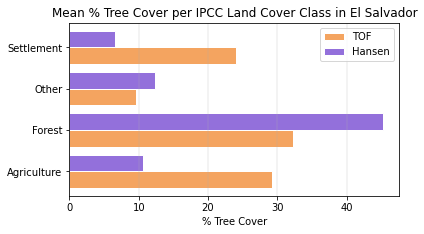

In [6]:
ipcc_means(es_above, (13,7), 'El Salvador')

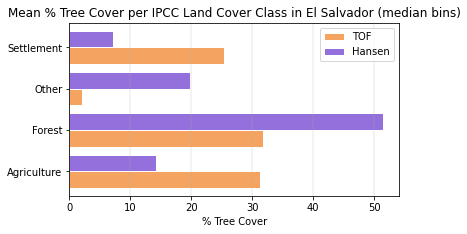

In [7]:
ipcc_means(es_above_new, (13,7), 'El Salvador (median bins)')

In [2]:
plt.figure(figsize=(13,7))

width = 0.4
pos1 = np.arange(len(nic_ipcc_means))
pos2 = pos1 + width

# Honduras
plt.subplot(2,2,1)
plt.barh(pos1, hon_ipcc_means['tof_mean_tc_lc'], width, color='sandybrown', edgecolor='white', label='TOF')
plt.barh(pos2, hon_ipcc_means['hans_mean_tc_lc'], width, color='mediumpurple', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, hon_ipcc_means['ipcc_class'].values)

plt.legend()
plt.title('Mean % Tree Cover per IPCC Land Cover Class in Honduras')
plt.grid(axis='x', linestyle='-', linewidth=.3)

# Nicaragua
plt.subplot(2,2,2)
plt.barh(pos1, nic_ipcc_means['tof_mean_tc_lc'], width, color='sandybrown', edgecolor='white', label='TOF')
plt.barh(pos2, nic_ipcc_means['hans_mean_tc_lc'], width, color='mediumpurple', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, nic_ipcc_means['ipcc_class'].values)

plt.legend()
plt.title('Mean % Tree Cover per IPCC Land Cover Class in Nicaragua')
plt.grid(axis='x', linestyle='-', linewidth=.3)


# Guatemala
plt.subplot(2,2,3)
plt.barh(pos1, gua_ipcc_means['tof_mean_tc_lc'], width, color='sandybrown', edgecolor='white', label='TOF')
plt.barh(pos2, gua_ipcc_means['hans_mean_tc_lc'], width, color='mediumpurple', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, gua_ipcc_means['ipcc_class'].values)

plt.legend()
plt.title('Mean % Tree Cover per IPCC Land Cover Class in Guatemala')
plt.grid(axis='x', linestyle='-', linewidth=.3)

# Panama
plt.subplot(2,2,4)
plt.barh(pos1, pan_ipcc_means['tof_mean_tc_lc'], width, color='sandybrown', edgecolor='white', label='TOF')
plt.barh(pos2, pan_ipcc_means['hans_mean_tc_lc'], width, color='mediumpurple', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, pan_ipcc_means['ipcc_class'].values)

plt.legend()
plt.title('Mean % Tree Cover per IPCC Land Cover Class in Panama')
plt.grid(axis='x', linestyle='-', linewidth=.3)
plt.tight_layout()

### Above IPCC Thresholds

In [33]:
def above_thresholds_ipcc(data): # takes in the country_above dataframe
    
    plt.figure(figsize=(15,12))

    # prepare the dataframes: groupby IPCC class, sum the total ha
    above_tof = data.drop(columns=[col for col in data.columns if col.startswith('hans')] + ['esa_id','tof_mean_tc_lc'])
    above_tof = above_tof.groupby('ipcc_class').sum().T.reset_index()
    
    above_hans = data.drop(columns=[col for col in data.columns if col.startswith('tof')] + ['esa_id','hans_mean_tc_lc'])
    above_hans = above_hans.groupby('ipcc_class').sum().T.reset_index()

    # format bars
    width = 0.4
    pos1 = np.arange(len(above_tof))
    pos2 = pos1 + width
    labels = ['>10%', '>20%', '>30%', '>40%', '>50%','>60%', '>70%', '>80%', '>90%']

    # Forest
    plt.subplot(2,2,1)
    plt.barh(pos1, above_tof['Forest'], width, color='dodgerblue', edgecolor='white', label='TOF')
    plt.barh(pos2, above_hans['Forest'], width, color='darkred', edgecolor='white', label='Hansen')

    plt.xlabel('Number of Hectares')
    plt.yticks(pos1 + width / 2, labels)
    plt.title('Tree Cover Thresholds for IPCC Forest Class')
    plt.grid(axis='x', linestyle='-', linewidth=.3)

    # Other
    plt.subplot(2,2,2)
    plt.barh(pos1, above_tof['Other'], width, color='dodgerblue', edgecolor='white', label='TOF')
    plt.barh(pos2, above_hans['Other'], width, color='darkred', edgecolor='white', label='Hansen')

    plt.xlabel('Number of Hectares')
    plt.yticks(pos1 + width / 2, labels)
    plt.title('Tree Cover Thresholds for IPCC Other Class')
    plt.grid(axis='x', linestyle='-', linewidth=.3)

    # Settlement
    plt.subplot(2,2,3)
    plt.barh(pos1, above_tof['Settlement'], width, color='dodgerblue', edgecolor='white', label='TOF')
    plt.barh(pos2, above_hans['Settlement'], width, color='darkred', edgecolor='white', label='Hansen')

    plt.xlabel('Number of Hectares')
    plt.yticks(pos1 + width / 2, labels)
    plt.title('Tree Cover Thresholds for IPCC Settlement Class')
    plt.grid(axis='x', linestyle='-', linewidth=.3)

    # Agriculture
    plt.subplot(2,2,4)
    plt.barh(pos1, above_tof['Agriculture'], width, color='dodgerblue', edgecolor='white', label='TOF')
    plt.barh(pos2, above_hans['Agriculture'], width, color='darkred', edgecolor='white', label='Hansen')

    plt.xlabel('Number of Hectares')
    plt.yticks(pos1 + width / 2, labels)
    plt.title('Tree Cover Thresholds for IPCC Agriculture Class')
    plt.grid(axis='x', linestyle='-', linewidth=.3)
    plt.legend();
    
    return None

In [ ]:
above_thresholds_ipcc(gua_above)

These charts illustrate the total number of hectares of tree cover over 10% increments for Hansen and TOF data. Total hectares are aggregated by IPCC land cover type across all the admin districts in a country. Specifically, this section looks at the comparisons by Forest, Agriculture, Other and Settlement IPCC land cover classes (not pictured: Grassland and Wetland).

In [ ]:
# sum num hectares in each threshold to see totals by IPCC class for Costa Rica
cr_ipcc_sums = cr_above.drop(columns=['esa_id', 'tof_mean_tc_lc', 'hans_mean_tc_lc']).groupby('ipcc_class').sum().reset_index()
cr_ipcc_sums

In [ ]:
cr_above_tof = cr_above.drop(columns=[col for col in cr_above.columns if col.startswith('hans')] + ['esa_id','tof_mean_tc_lc'])
cr_above_tof = cr_above_tof.groupby('ipcc_class').sum().T.reset_index()

In [ ]:
cr_above_hans = cr_above.drop(columns=[col for col in cr_above.columns if col.startswith('tof')] + ['esa_id','hans_mean_tc_lc'])
cr_above_hans = cr_above_hans.groupby('ipcc_class').sum().T.reset_index()

In [ ]:
mean_per_ipcc = landcover[['tof_mean_tc', 
                           'hansen_mean_tc', 
                           'ipcc_class']].groupby('ipcc_class').mean().reset_index()
plt.figure(figsize=(8,6))

width = 0.4
pos1 = np.arange(len(mean_per_ipcc))
pos2 = pos1 + width

plt.barh(pos1, mean_per_ipcc['tof_mean_tc'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, mean_per_ipcc['hansen_mean_tc'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, mean_per_ipcc['ipcc_class'].values)

plt.legend()
plt.title('Mean Percent Tree Cover per IPCC Land Cover Classes')
plt.grid(axis='x', linestyle='-', linewidth=.3);


In [ ]:
ha_per_ipcc = landcover[['tof_total_ha', 
                        'hansen_total_ha', 
                        'ipcc_class']].groupby('ipcc_class').sum().reset_index()

plt.figure(figsize=(13,5))

width = 0.4
pos1 = np.arange(len(ha_per_ipcc))
pos2 = pos1 + width

plt.barh(pos1, ha_per_ipcc['tof_total_ha'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, ha_per_ipcc['hansen_total_ha'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, ha_per_ipcc['ipcc_class'].values)

plt.legend()
plt.title('Total Hectares Tree Cover per IPCC Land Cover Classes')
plt.grid(axis='x', linestyle='-', linewidth=.3);


In [ ]:
ha_per_lc = landcover[['tof_total_ha', 
                       'hansen_total_ha', 
                       'lc_class']].groupby('lc_class').sum().sort_values('tof_total_ha').reset_index()

mean_per_lc = landcover[['tof_mean_tc', 
                       'hansen_mean_tc', 
                       'lc_class']].groupby('lc_class').mean().sort_values('tof_mean_tc').reset_index()

In [ ]:
plt.figure(figsize=(10,8))

width = 0.4
pos1 = np.arange(len(mean_per_lc))
pos2 = pos1 + width

plt.barh(pos1, mean_per_lc['tof_mean_tc'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, mean_per_lc['hansen_mean_tc'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, mean_per_lc['lc_class'].values)

plt.legend()
plt.title('Mean Percent Tree Cover per Land Cover Class')
plt.grid(axis='x', linestyle='-', linewidth=.3);

In [ ]:
plt.figure(figsize=(10,8))

width = 0.4
 
# Set position of bar on X axis
pos1 = np.arange(len(ha_per_lc))
pos2 = pos1 + width

plt.barh(pos1, ha_per_lc['tof_total_ha'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, ha_per_lc['hansen_total_ha'], width, color='darkred', edgecolor='white', label='Hansen')
 
# Add xticks on the middle of the group bars
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, ha_per_lc['lc_class'].values)
 
# Create legend & Show graphic
plt.legend()
plt.title('Total Hectares of Tree Cover per Land Cover Class')
plt.grid(axis='x', linestyle='-', linewidth=.3);

In [ ]:
# zoom in on land categories with smaller count

plt.figure(figsize=(10,8))

width = 0.4
 
# Set position of bar on X axis
pos1 = np.arange(0,7)
pos2 = pos1 + width

plt.barh(pos1, ha_per_lc['tof_total_ha'][:7], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, ha_per_lc['hansen_total_ha'][:7], width, color='darkred', edgecolor='white', label='Hansen')
 
# Add xticks on the middle of the group bars
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, ha_per_lc['lc_class'].values[:7])
 
# Create legend & Show graphic
plt.legend()
plt.title('Total Hectares of Tree Cover per Land Cover Class (<700ha)')
plt.grid(axis='x', linestyle='-', linewidth=.2);

### Urban
What does tree cover look like in the urban land cover class?

In [ ]:
# get the sum of ha of tree cover for each 10% threshold
es = pd.read_csv('El Salvador/El Salvador_statistics.csv')
urban = es[es.esa_id == 190]
urban = urban.groupby(by=['admin', 'tree_cover_class']).sum().reset_index()
urban = urban[['admin', 'tree_cover_class', 'esa_sampled_ha', 'esa_total_ha', 'tof_ha']]
urban_usulutan = urban[urban.admin == 'Usulután']

plt.figure(figsize = (8,6))
x = ['0-9%','10-19%','20-29%','30-39%','40-49%','50-59%','60-69%','70-79%','80-89%','90-99%']
#x = list(sorted(set(urban_usulutan.tree_cover_class)))

variance = [15, 20, 4, 12, 4, 5, 10, 6, 8, 10]

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, list(urban_usulutan.tof_ha), color='green', xerr=variance)
plt.ylabel(" ")
plt.xlabel("Total ha")
plt.title("Urban Tree Cover by Threshold: Usulután, El Salvador")

plt.yticks(x_pos, x);

### Which cities have the most urban tree cover?

In [ ]:
def top_5_cities(data, figsize, barwidth): # data is above or between dataframe
    
    # filter the dataframe to top 5 cities with highest tof avg
    settlement = data[data.ipcc_class == 'Settlement'].sort_values('tof_mean_tc_lc', ascending=False)[:5]
    
    labels = settlement.admin
    x = np.arange(len(labels))  
    width = barwidth  
    
    plt.figure(figsize=figsize)
    plt.bar(x - width/2, settlement.tof_mean_tc_lc, width, label='TOF', color='navy', edgecolor='white')
    plt.bar(x + width/2, settlement.hans_mean_tc_lc, width, label='Hansen', color='darkred', edgecolor='white')

    plt.title('Top 5 Cities with Highest Avg % Tree Cover (TOF)')
    plt.ylabel('% Tree Cover')    
    plt.xticks(x, labels=labels, rotation=60)
    plt.grid(axis='y', linestyle='-', linewidth=.2)
    plt.legend()
    plt.tight_layout()
    
    return None

In [ ]:
top_5_cities(es_above, (9,7), 0.35)

In [ ]:
# filter the dataframe to top 5 cities with highest tof avg
ag = gua_above[gua_above.ipcc_class == 'Agriculture'].sort_values('tof_mean_tc_lc', ascending=False)[:10]

labels = ag.admin
x = np.arange(len(labels))  
width = .35  

plt.figure(figsize=(9,7))
plt.bar(x - width/2, ag.tof_mean_tc_lc, width, label='TOF', color='navy', edgecolor='white')
plt.bar(x + width/2, ag.hans_mean_tc_lc, width, label='Hansen', color='darkred', edgecolor='white')

plt.title('Trees in Ag Areas in Guatemala')
plt.ylabel('% Tree Cover')    
plt.xticks(x, labels=labels, rotation=60)
plt.grid(axis='y', linestyle='-', linewidth=.2)
plt.legend()
plt.tight_layout()

### Agriculture
What does tree cover look like in the urban land cover class?

In [ ]:
plt.figure(figsize = (8,6))
x = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
totals = [gua_ag.tof_0_20.sum(),
          gua_ag.tof_20_40.sum(),
          gua_ag.tof_40_60.sum(),
          gua_ag.tof_60_80.sum(),
          gua_ag.tof_80_100.sum()]

variance = [25000, 20000, 74000, 92000, 45000]

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, totals, color='green', xerr=variance)
plt.ylabel(" ")
plt.xlabel("Total ha")
plt.title("Tree Cover in Agriculture in Guatemala")

plt.yticks(x_pos, x)

plt.show()

### Total Hectares per Class: Hansen v TOF
What does the distribution look like across all land cover classes?

In [ ]:
# All land cover classes 
fig, ax = plt.subplots(figsize=(12,10))

sns.scatterplot(x='tof_total_ha', 
               y='hansen_total_ha', 
               data=landcover, 
               hue='lc_class',
               marker='x',
               s=30,
               palette=colors,
               ax=ax)
ax.set(xlim=(0, 8000), ylim=(0, 8000))
ax.plot(np.arange(0.001, 8000, 1), color='grey', linewidth=.2)
ax.set_title('Hectares of Tree Cover per Land Cover Class')
ax.set_xlabel('TOF total hectares')
ax.set_ylabel('Hansen total hectares')


plt.legend(bbox_to_anchor=(1.0, 1), title='ESA Land Cover Class');

In [ ]:
cr_above_tof = cr_above.drop(columns=[col for col in cr_above.columns if col.startswith('hans')] + ['esa_id','tof_mean_tc_lc'])
cr_above_tof = cr_above_tof.groupby('ipcc_class').sum().T.reset_index()

In [ ]:
cr_above_hans = cr_above.drop(columns=[col for col in cr_above.columns if col.startswith('tof')] + ['esa_id','hans_mean_tc_lc'])
cr_above_hans = cr_above_hans.groupby('ipcc_class').sum().T.reset_index()

In [ ]:
mean_per_ipcc = landcover[['tof_mean_tc', 
                           'hansen_mean_tc', 
                           'ipcc_class']].groupby('ipcc_class').mean().reset_index()
plt.figure(figsize=(8,6))

width = 0.4
pos1 = np.arange(len(mean_per_ipcc))
pos2 = pos1 + width

plt.barh(pos1, mean_per_ipcc['tof_mean_tc'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, mean_per_ipcc['hansen_mean_tc'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, mean_per_ipcc['ipcc_class'].values)

plt.legend()
plt.title('Mean Percent Tree Cover per IPCC Land Cover Classes')
plt.grid(axis='x', linestyle='-', linewidth=.3);


In [ ]:
# El Salvador: total ha >10% cover per IPCC class

forest = es_above[es_above.ipcc_class == 'Forest']
agriculture = es_above[es_above.ipcc_class == 'Agriculture']
settlement = es_above[es_above.ipcc_class == 'Settlement']
grassland = es_above[es_above.ipcc_class == 'Grassland']
wetland = es_above[es_above.ipcc_class == 'Wetland']
other = es_above[es_above.ipcc_class == 'Other']

plt.figure(figsize=(14,14))

ax1 = plt.subplot(3,2,1)
sns.scatterplot(x='tof_10+', 
               y='hans_10+', 
               data=forest, 
               hue='esa_class',
               marker='x',
               s=30,
               #palette=colors[:5],
               ax=ax1,
               legend=False)
ax1.set(xlim=(0, 20000), ylim=(0, 20000))
ax1.plot(np.arange(0.001, 20000, 1), color='grey', linewidth=.2)
ax1.set_title('Total ha with >10% cover IPCC Forest Class')
ax1.set_xlabel('TOF total ha')
ax1.set_ylabel('Hansen total ha')

ax2 = plt.subplot(3,2,2)
sns.scatterplot(x='tof_10+', 
               y='hans_10+', 
               data=agriculture, 
               hue='esa_class',
               marker='x',
               s=30,
               #palette=colors[4:8],
               ax=ax2,
               legend=False)
ax2.set(xlim=(0, 12000), ylim=(0, 12000))
ax2.plot(np.arange(0.001, 12000, 1), color='grey', linewidth=.2)
ax2.set_title('Total ha with >10% cover IPCC Agriculture Class')
ax2.set_xlabel('TOF total ha')
ax2.set_ylabel('Hansen total ha')


ax3 = plt.subplot(3,2,3)
sns.scatterplot(x='tof_10+', 
               y='hans_10+', 
               data=settlement, 
               hue='esa_class',
               marker='x',
               s=30,
               #palette=colors[8:9],
               ax=ax3,
               legend=False)
ax3.set(xlim=(0, 4000), ylim=(0, 4000))
ax3.plot(np.arange(0.001, 4000, 1), color='grey', linewidth=.2)
ax3.set_title('Total ha with >10% cover IPCC Settlement Class')
ax3.set_xlabel('TOF total ha')
ax3.set_ylabel('Hansen total ha')

ax4 = plt.subplot(3,2,4)
sns.scatterplot(x='tof_10+', 
               y='hans_10+', 
               data=grassland, 
               hue='esa_class',
               marker='x',
               s=30,
               #palette=colors[9:11],
               ax=ax4,
               legend=False)
ax4.set(xlim=(0, 300), ylim=(0, 300))
ax4.plot(np.arange(0.001, 1000, 1), color='grey', linewidth=.2)
ax4.set_title('Total ha with >10% cover IPCC Grassland Class')
ax4.set_xlabel('TOF total ha')
ax4.set_ylabel('Hansen total ha')

ax5 = plt.subplot(3,2,5)
sns.scatterplot(x='tof_10+', 
               y='hans_10+', 
               data=wetland, 
               hue='esa_class',
               marker='x',
               s=30,
               #palette=colors[11:12],
               ax=ax5,
               legend=False)
ax5.set(xlim=(0, 100), ylim=(0, 100))
ax5.plot(np.arange(0.001, 100, 1), color='grey', linewidth=.2)
ax5.set_title('Total ha with >10% cover IPCC Wetland Class')
ax5.set_xlabel('TOF total ha')
ax5.set_ylabel('Hansen total ha')

ax6 = plt.subplot(3,2,6)
sns.scatterplot(x='tof_10+', 
               y='hans_10+', 
               data=other, 
               hue='esa_class',
               marker='x',
               s=30,
               #palette=colors[12:],
               ax=ax6,
               legend=False)
ax6.set(xlim=(0, 6000), ylim=(0, 6000))
ax6.plot(np.arange(0.001, 6000, 1), color='grey', linewidth=.2)
ax6.set_title('Total ha for IPCC Other Class')
ax6.set_xlabel('TOF total ha')
ax6.set_ylabel('Hansen total ha')

# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
plt.tight_layout();


In [ ]:
plt.figure(figsize=(16,10))
opico_esa = rs.open('El Salvador/clipped_rasters/esa/Opico.tif').read(1)
opico = landcover[landcover.jurisdiction == 'Opico']


plt.figure(figsize=(13,5))

width = 0.4
pos1 = np.arange(len(ha_per_ipcc))
pos2 = pos1 + width

plt.barh(pos1, ha_per_ipcc['tof_total_ha'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, ha_per_ipcc['hansen_total_ha'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, ha_per_ipcc['ipcc_class'].values)

plt.legend()
plt.title('Total Hectares Tree Cover per IPCC Land Cover Classes')
plt.grid(axis='x', linestyle='-', linewidth=.3);


In [ ]:
ha_per_lc = landcover[['tof_total_ha', 
                       'hansen_total_ha', 
                       'lc_class']].groupby('lc_class').sum().sort_values('tof_total_ha').reset_index()

mean_per_lc = landcover[['tof_mean_tc', 
                       'hansen_mean_tc', 
                       'lc_class']].groupby('lc_class').mean().sort_values('tof_mean_tc').reset_index()

In [ ]:
plt.figure(figsize=(10,8))

width = 0.4
pos1 = np.arange(len(mean_per_lc))
pos2 = pos1 + width

plt.barh(pos1, mean_per_lc['tof_mean_tc'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, mean_per_lc['hansen_mean_tc'], width, color='darkred', edgecolor='white', label='Hansen')
 
plt.xlabel('% Tree Cover')
plt.yticks(pos1 + width / 2, mean_per_lc['lc_class'].values)

plt.legend()
plt.title('Mean Percent Tree Cover per Land Cover Class')
plt.grid(axis='x', linestyle='-', linewidth=.3);

In [ ]:
plt.figure(figsize=(10,8))

width = 0.4
 
# Set position of bar on X axis
pos1 = np.arange(len(ha_per_lc))
pos2 = pos1 + width

plt.barh(pos1, ha_per_lc['tof_total_ha'], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, ha_per_lc['hansen_total_ha'], width, color='darkred', edgecolor='white', label='Hansen')
 
# Add xticks on the middle of the group bars
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, ha_per_lc['lc_class'].values)
 
# Create legend & Show graphic
plt.legend()
plt.title('Total Hectares of Tree Cover per Land Cover Class')
plt.grid(axis='x', linestyle='-', linewidth=.3);

In [ ]:
# zoom in on land categories with smaller count

plt.figure(figsize=(10,8))

width = 0.4
 
# Set position of bar on X axis
pos1 = np.arange(0,7)
pos2 = pos1 + width

plt.barh(pos1, ha_per_lc['tof_total_ha'][:7], width, color='dodgerblue', edgecolor='white', label='TOF')
plt.barh(pos2, ha_per_lc['hansen_total_ha'][:7], width, color='darkred', edgecolor='white', label='Hansen')
 
# Add xticks on the middle of the group bars
plt.xlabel('Tree Cover (ha)')
plt.yticks(pos1 + width / 2, ha_per_lc['lc_class'].values[:7])
 
# Create legend & Show graphic
plt.legend()
plt.title('Total Hectares of Tree Cover per Land Cover Class (<700ha)')
plt.grid(axis='x', linestyle='-', linewidth=.2);

### Urban Areas: El Salvador and Guatemala
What does tree cover look like in the urban land cover class?  
Which cities have the most urban tree cover?

In [108]:
def top_5_cities(data, figsize, barwidth): # data is above or between dataframe
    
    # filter the dataframe to top 5 cities with highest tof avg
    settlement = data[data.ipcc_class == 'Settlement'].sort_values('tof_mean_tc_lc', ascending=False)[:5]
    
    labels = settlement.admin
    x = np.arange(len(labels))  
    width = barwidth  
    
    plt.figure(figsize=figsize)
    plt.bar(x - width/2, settlement.tof_mean_tc_lc, width, label='TOF', color='navy', edgecolor='white')
    plt.bar(x + width/2, settlement.hans_mean_tc_lc, width, label='Hansen', color='darkred', edgecolor='white')

    plt.title('Top 5 Cities with Highest Avg % Tree Cover (TOF)')
    plt.ylabel('% Tree Cover')    
    plt.xticks(x, labels=labels, rotation=60)
    plt.grid(axis='y', linestyle='-', linewidth=.2)
    plt.legend()
    plt.tight_layout()
    
    return None

In [ ]:
top_5_cities(es_above, (9,7), 0.35)

In [ ]:
# filter the dataframe to top 5 cities with highest tof avg
ag = gua_above[gua_above.ipcc_class == 'Agriculture'].sort_values('tof_mean_tc_lc', ascending=False)[:10]

labels = ag.admin
x = np.arange(len(labels))  
width = .35  

plt.figure(figsize=(9,7))
plt.bar(x - width/2, ag.tof_mean_tc_lc, width, label='TOF', color='navy', edgecolor='white')
plt.bar(x + width/2, ag.hans_mean_tc_lc, width, label='Hansen', color='darkred', edgecolor='white')

plt.title('Trees in Ag Areas in Guatemala')
plt.ylabel('% Tree Cover')    
plt.xticks(x, labels=labels, rotation=60)
plt.grid(axis='y', linestyle='-', linewidth=.2)
plt.legend()
plt.tight_layout()

## Old Visuals

In [4]:
def h_groupedbar(bar_tof, bar_han, figsize, barwidth, labels, title, xlabel):
    
    '''
    Plots a horizontal grouped bar chart comparing Hansen (red) and TOF (blue) 
    estimates of the total number of hectares of land that fall into different
    tree cover thresholds.
    '''
    
    #ylabels = labels
    y = np.arange(len(labels))
    width = barwidth

    plt.figure(figsize=figsize)
    plt.barh(y - width/2, bar_tof, width, label='TOF', color='dodgerblue', edgecolor='white')
    plt.barh(y + width/2, bar_han, width, label='Hansen', color='orangered', edgecolor='white')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.yticks(y + width / 2, labels=labels)
    plt.grid(axis='x', linestyle='-', linewidth=.2)
    plt.legend()
    plt.tight_layout()
    
    return None

### Average % tree cover per admin
The vertical grouped bar charts compare Hansen (red) and TOF (blue) mean tree cover estimates per admin 1 boundary for a given country. This will give us a general comparison, indicate errors if we see zero tree cover, and illustrates the need to mosaic Hansen and TOF data together at some point.

In [ ]:
def v_groupedbar_mean(bar_tof, bar_han, figsize, barwidth, labels, title):
    
    '''
    Plots a vertical grouped bar chart comparing Hansen (red) and TOF (blue) 
    mean tree cover estimates per admin 1 boundary for a given country. 
    '''
    
    #xlabels = labels
    x = np.arange(len(labels))  
    width = barwidth  

    plt.figure(figsize=figsize)
    plt.bar(x - width/2, bar_tof, width, label='TOF', color='navy', edgecolor='white')
    plt.bar(x + width/2, bar_han, width, label='Hansen', color='darkred', edgecolor='white')

    plt.title(title)
    plt.ylabel('% Tree Cover')
    plt.xlabel('Admin')
    plt.xticks(x, labels=labels, rotation=60)
    plt.grid(axis='y', linestyle='-', linewidth=.2)
    plt.legend()
    plt.tight_layout()
    
    return None

In [ ]:
v_groupedbar_mean(hon.tof_mean_tc, 
                  hon.hans_mean_tc, 
                  (9,5), 
                  0.35, 
                  list(hon.admin), 
                  'Avg % Tree Cover for Admin Districts in Honduras')

In [ ]:
v_groupedbar_mean(gua.tof_mean_tc, 
                  gua.hans_mean_tc, 
                  (9,5), 
                  0.35, 
                  list(gua.admin), 
                  'Avg % Tree Cover for Admin Districts in Guatemala')

In [ ]:
v_groupedbar_mean(pan.tof_mean_tc, 
                  pan.hans_mean_tc, 
                  (9,5), 
                  0.35, 
                  list(pan.admin), 
                  'Avg % Tree Cover for Admin Districts in Panama')

In [ ]:
v_groupedbar_mean(nic.tof_mean_tc, 
                  nic.hans_mean_tc, 
                  (9,5), 
                  0.35, 
                  list(nic.admin), 
                  'Avg % Tree Cover for Admin Districts in Nicaragua')

### Average and Total Difference per Class
What is the average and total difference between TOF and Hansen tree cover estimates?

In [ ]:
# Plots the average difference between total hecatares of tof and hansen for each land cover class
# the tof_hans column is calculated by tof total ha - hansen total ha

diverge_mean = landcover.groupby('lc_class')['tof_hans'].mean().sort_values().reset_index()
diverge_sum = landcover.groupby('lc_class')['tof_hans'].sum().sort_values().reset_index()
colors = ['red' if x < 0 else 'green' for x in diverge_mean.tof_hans]

plt.figure(figsize=(10,6))

plt.hlines(y=diverge_mean.lc_class, 
           xmin=0, 
           xmax=diverge_mean.tof_hans, 
           alpha=0.7,
           linewidth=5)

plt.title('Average difference in hectares of tree cover per land cover class: TOF vs Hansen')
plt.xlabel('ha tree cover');

In [ ]:
plt.figure(figsize=(10,6))

plt.hlines(y=diverge_sum.lc_class, 
           xmin=0, 
           xmax=diverge_sum.tof_hans, 
           alpha=0.7,
           linewidth=5)

plt.title('Total difference in hectares of tree cover per land cover class: TOF vs Hansen')
plt.xlabel('ha tree cover');